# Fast.ai and CF

Original dataset to be used can be obtained from here: https://www.kaggle.com/zygmunt/goodbooks-10k

In [70]:
from fastai.collab import *

In [71]:
!wget https://github.com/MindaugasBernatavicius/DeepLearningCourse/raw/master/11_Recommender_Systems/goodbooks-10k.zip
!unzip -f goodbooks-10k.zip

--2021-02-08 22:05:35--  https://github.com/MindaugasBernatavicius/DeepLearningCourse/raw/master/11_Recommender_Systems/goodbooks-10k.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MindaugasBernatavicius/DeepLearningCourse/master/11_Recommender_Systems/goodbooks-10k.zip [following]
--2021-02-08 22:05:35--  https://raw.githubusercontent.com/MindaugasBernatavicius/DeepLearningCourse/master/11_Recommender_Systems/goodbooks-10k.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12155229 (12M) [application/zip]
Saving to: ‘goodbooks-10k.zip.4’

goodbooks-10k.zip.4 100%[===================>]  11.59M 

In [72]:
path = Path('./')
path.ls()

[PosixPath('.config'),
 PosixPath('sample_book.xml'),
 PosixPath('goodbooks-10k.zip.2'),
 PosixPath('book_tags.csv'),
 PosixPath('tags.csv'),
 PosixPath('goodbooks-10k.zip.3'),
 PosixPath('models'),
 PosixPath('goodbooks-10k.zip.4'),
 PosixPath('goodbooks-10k.zip'),
 PosixPath('ratings.csv'),
 PosixPath('goodbooks-10k.zip.1'),
 PosixPath('to_read.csv'),
 PosixPath('books.csv'),
 PosixPath('sample_data')]

In [73]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


Generally, a DataBunch in fastai is the data collector object that ‘bunches’ together several PyTorch classes into one. In PyTorch the Dataset contains all labels, and the DataLoader gives the model chunks of the items in the Dataset. The fastai DataBunch bundles a Dataset and a Dataloader (for both training and validation sets) into a single object.

The parameters:
- ratings - the data that will be used - it has to be in the form that we already have it in.
- seed - just a seed to generate random numbers from that would initialize weight
- valid_pct - the percentage to treat as validation data
- ... and then the three collumns from which the user and book embeddings are going to be calculated.

In [74]:
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0.1, user_name='user_id', item_name='book_id', rating_name='rating')

In [75]:
data.show_batch()

user_id,book_id,target
13712,1664,5.0
37943,4352,5.0
28815,9218,3.0
19420,5854,5.0
27398,1168,3.0


We will need to suply the y range, which will be range of values to be predicted. So let's calculate them.

In [76]:
ratings.rating.min(), ratings.rating.max()

(1, 5)

Collab_learner creates a learner for collaborative filtering on data. More specifically, it binds data with a model that is either an EmbeddingDotBias with n_factors if use_nn = False or an EmbeddingNN otherwise: 
- EmbeddingDotBias is a Pytorch model to find embeddings. It is a standard multi-layer perceptron without biases and one hidden layer. This model is faster and simpler.
- EmbeddingNN, instead, creates a deeper Neural Network suitable for collaborative filtering. This model has additional flexibility of allowing to specify different embeddeing sizes and has the potential of being more preceise if tunned.

## EmbeddingDotBias Model

We can pass the collab learner:
- n_factors argument which represents the size of the embedding vectors
- yrange argument which specifies the range of the rating values.
- wd - weight decay

In [77]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")

In [78]:
print(learn.summary())

EmbeddingDotBias
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [40]                 2,134,040  True      
______________________________________________________________________
Embedding            [40]                 400,040    True      
______________________________________________________________________
Embedding            [1]                  53,351     True      
______________________________________________________________________
Embedding            [1]                  10,001     True      
______________________________________________________________________

Total params: 2,597,432
Total trainable params: 2,597,432
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FlattenedLoss
Callbacks functions applied 



Leslie N. Smith research for lr finding and OCP (one-cycle policy)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


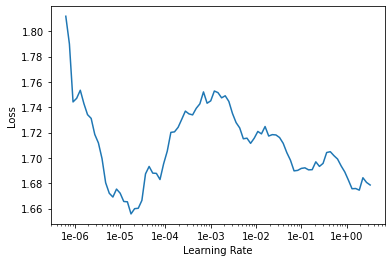

In [79]:
learn.lr_find()
learn.recorder.plot()

How to determine which lr to choise from this diagram?

In [80]:
# Since one zero is equivelant to -1 order of magnitude
print(10e-2 == 1e-1)

# That means
print(10e-2 > 5e-2 > 1e-2)

True
True


In [81]:
learn.fit_one_cycle(1, 8e-5) # TODO validate that the optimal LR rate is chosen

epoch,train_loss,valid_loss,time
0,1.664715,1.651175,01:34


In [82]:
learn.save('goodbooks-dot-1')

## EmbeddingNN Model

The basic model to find these latent factor matrices is a standard multi-layer perceptron without biases and identity activation functions. Note that we could use different embedding layer sizes this case!

In [83]:
learn = collab_learner(data, use_nn=True, emb_szs={'user_id': 40, 'book_id':40}, layers=[256, 128], y_range=(1, 5))
print(learn.summary())

EmbeddingNN
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [40]                 2,134,040  True      
______________________________________________________________________
Embedding            [40]                 400,040    True      
______________________________________________________________________
Dropout              [80]                 0          False     
______________________________________________________________________
Linear               [256]                20,736     True      
______________________________________________________________________
ReLU                 [256]                0          False     
______________________________________________________________________
BatchNorm1d          [256]                512        True      
______________________________________________________________________
Linear               [128]                32,896     True      
__________________________________________________

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


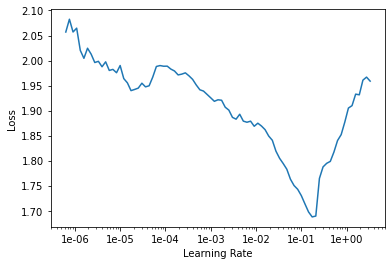

In [84]:
learn.lr_find()
learn.recorder.plot()

In [85]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,time
0,0.758849,0.732033,02:08


In [86]:
learn.save('goodbooks-nn-1')

In [87]:
books = pd.read_csv(path/'books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


Obtain the top rated books. Remember, ratings is the origina data.

 You need to tie the books['id'] with the ratings[ratings['book_id']

In [88]:
ratings[ratings['book_id'] == 5000]
books[books['id'] == 5000]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
4999,5000,4701550,4701550,4765865,24,446401056,9.780446e+12,Larissa Ione,2009.0,Passion Unleashed,Passion Unleashed (Demonica #3),eng,4.32,28493,29915,1102,266,690,3868,9459,15632,https://images.gr-assets.com/books/1344267582m...,https://images.gr-assets.com/books/1344267582s...


In [89]:
g = ratings.groupby('book_id')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_books = top_books.astype(str)
top_books[:10]

array(['5000', '3315', '3313', '3312', '3311', '3309', '3308', '3307', '3306', '3304'], dtype='<U21')

In [90]:
top_books_with_name = []
for book in top_books:
    pandas_series_title = books[books['id'] == int(book)]['title']
    if not pandas_series_title.empty:
        top_books_with_name.append(pandas_series_title.iloc[0])

top_books_with_name = np.array(top_books_with_name)
top_books_with_name

array(['Passion Unleashed (Demonica #3)', 'My Story', 'The Gargoyle', 'Pretty Baby', ...,
       'Top Secret Twenty-One (Stephanie Plum, #21)', 'The Warrior Heir (The Heir Chronicles, #1)', 'Stone Soup',
       'The Sixth Man (Sean King & Michelle Maxwell, #5)'], dtype='<U144')

With fast.ai we can easily obtain the biases and weight separatelly and then do some analysis on those.

## Book Bias

In [95]:
# learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")
learn.load('./goodbooks-dot-1');

FileNotFoundError: ignored

In [92]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(53351, 40)
    (1): Embedding(10001, 40)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=80, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [93]:
book_bias = learn.bias(top_books, is_item=True)

ModuleAttributeError: ignored

In [ ]:
print(len(top_books))
print(len(book_bias))
print(len(mean_ratings))
print(len(top_books_with_name))

In [ ]:
mean_ratings = ratings.groupby('book_id')['rating'].mean()
book_ratings = [(b, top_books_with_name[i], mean_ratings.loc[int(tb)]) for i, (tb, b) in enumerate(zip(top_books, book_bias))]

Low bias - the book is in general rated poorly, high bias - the book is in general rated highly. The `lambda o:o[0]` is just a function to get the first value of the list for each list

In [ ]:
sorted(book_ratings, key=lambda o:o[0])[:15]

In [ ]:
sorted(book_ratings, key=lambda o:o[0], reverse=True)[:15]

## Book weights

What can we do with weights? We can plot PCA!

In [ ]:
book_w = learn.weight(top_books, is_item=True)
book_w.shape

We will want a 3 factor PCA, we can plot only two, but that does not mean we have too choose which 2 upfront.

In [ ]:
book_pca = book_w.pca(3)
book_pca.shape

Since we obtained the weights from top_books, the weights and the names of the books are in the same order, so we can group PCA factors and the pca factor1 score can be zipped together with the names of books. And what we should see is that the books that we think are similar should be displayed close to each other.

In [ ]:
fac0,fac1,fac2 = book_pca.t()
book_comp = [(f, i) for f,i in zip(fac0, top_books_with_name)]

In [ ]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(book_comp, key=itemgetter(0))[:10]

Do the same for the seconf factor

In [ ]:
book_comp = [(f, i) for f,i in zip(fac1, top_books_with_name)]

In [ ]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(book_comp, key=itemgetter(0))[:10]

Let's plot the books against each other using the two factors as features

In [ ]:
idxs = np.random.choice(len(top_books_with_name), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_books_with_name[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()